In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Pandas display options to supress scientifc notation and show all columns and all rows if necessary. Puts a lot of strain of processor

In [2]:
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
pd.options.display.float_format= '{:.2f}'.format

In [3]:
nyse = pd.read_csv(os.path.join('Resources', 'nyse.csv'))
nasdaq = pd.read_csv(os.path.join('Resources', 'nasdaq.csv'))
amex = pd.read_csv(os.path.join('Resources', 'amex.csv'))

In [4]:
frames = [nyse, nasdaq, amex]
tickers = pd.concat(frames).sort_values(by='Ticker')

In [34]:
data_2018 = pd.read_csv(os.path.join('Resources', '2018_Financial_Data.csv')).\
rename(columns={'Unnamed: 0':'Ticker'}).\
sort_values(by='Ticker').\
reset_index(drop=True)

df = tickers.merge(data_2018, on='Ticker')

Note: In *__data_2018__* we had 4392 observations. When we merged with our *__tickers__* dataframe which had 8000+ tickers and company names from exchanges we lost 150 observations. These can be retrieved with 
``` 
data_2018[~data_2018.Ticker.isin(tickers['Ticker'])]
```
Here the **~** symbol essentially means NOT IN when we filter

Lastly, a dataframe with just indicators we can manipulate. We can filter out some of the columns containing information we don't need then pass this as a filter to our working dataframe with ```df[x['indicator']]```

In [135]:
indicators = pd.DataFrame({
   'Indicator': df.iloc[:,2:-3].columns.tolist()
})

x = indicators[indicators['Indicator'].str.contains('Growth|Margin|growth|ratio') == False]

## Conditional Filtering

In [ ]:
tickers[tickers['Company Name'].str.contains('Bond') == True];

In [113]:
df[df['Company Name'].str.contains('Bond') == True];

In [ ]:
df[df['Ticker'].str.startswith('X') == True];

In [140]:
df[df['Revenue Growth'] > 10].sort_values(by='Revenue Growth', ascending=False);

## Graphs and Visualizations

Following two cells achieve the same result by diff methods

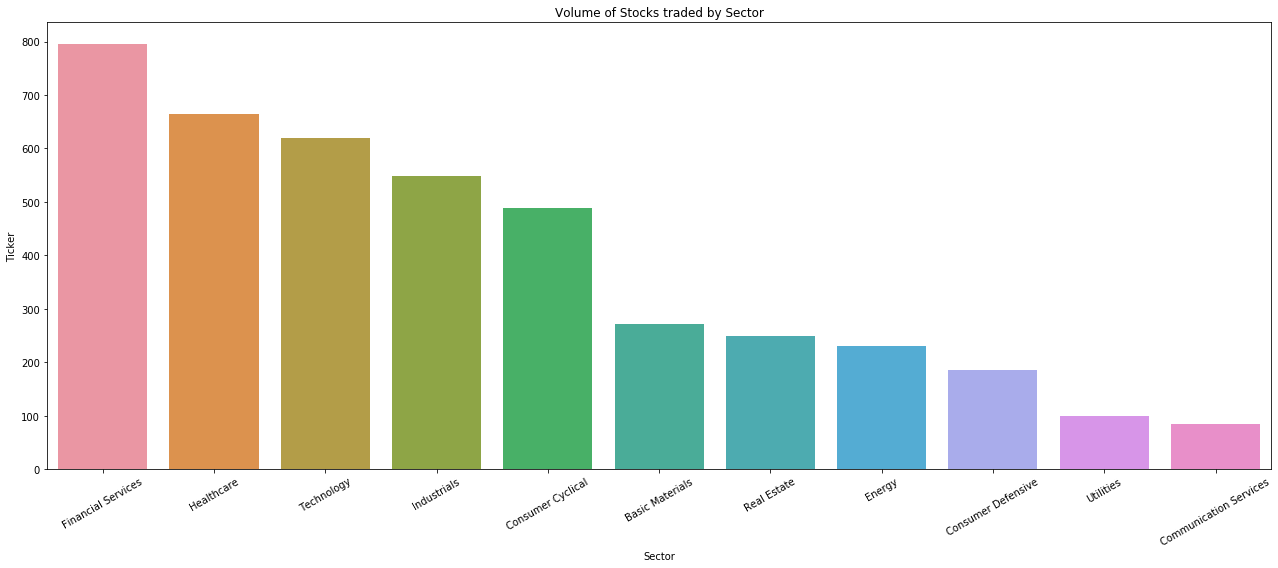

In [35]:
sector_count = pd.DataFrame(df.groupby(['Sector']).count()['Ticker']).reset_index().sort_values(by='Ticker', ascending=False)

plt.figure(figsize=(18,8))
plt.title('Volume of Stocks traded by Sector')
sns.barplot(x = sector_count['Sector'], y = sector_count['Ticker']).set_xticklabels(labels = sector_count['Sector'], rotation=30)
plt.tight_layout()
# plt.savefig(os.path.join('Figures','StockVolume_Sector.png'))

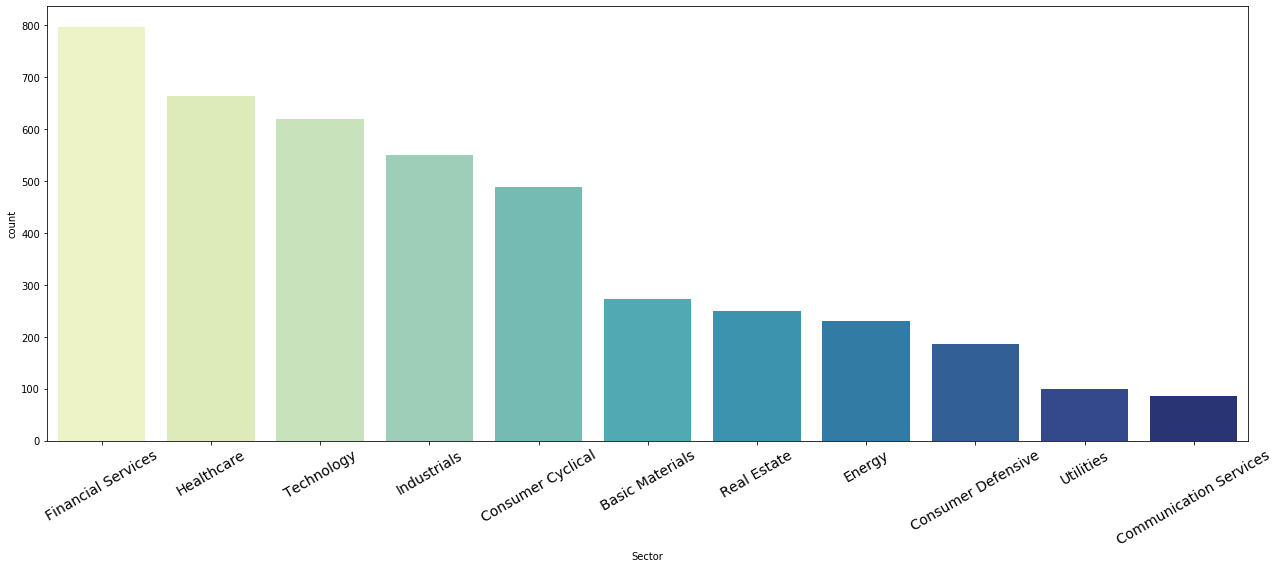

In [143]:
plt.figure(figsize=(18,8))
sns.countplot(x='Sector', data = df, palette='YlGnBu', order=df['Sector'].value_counts().index).set_xticklabels(labels = df['Sector'].value_counts().index, fontdict={'fontsize': 14},rotation=30)
plt.tight_layout()
# plt.savefig(os.path.join('Figures','StockVolume_Sector.png'))

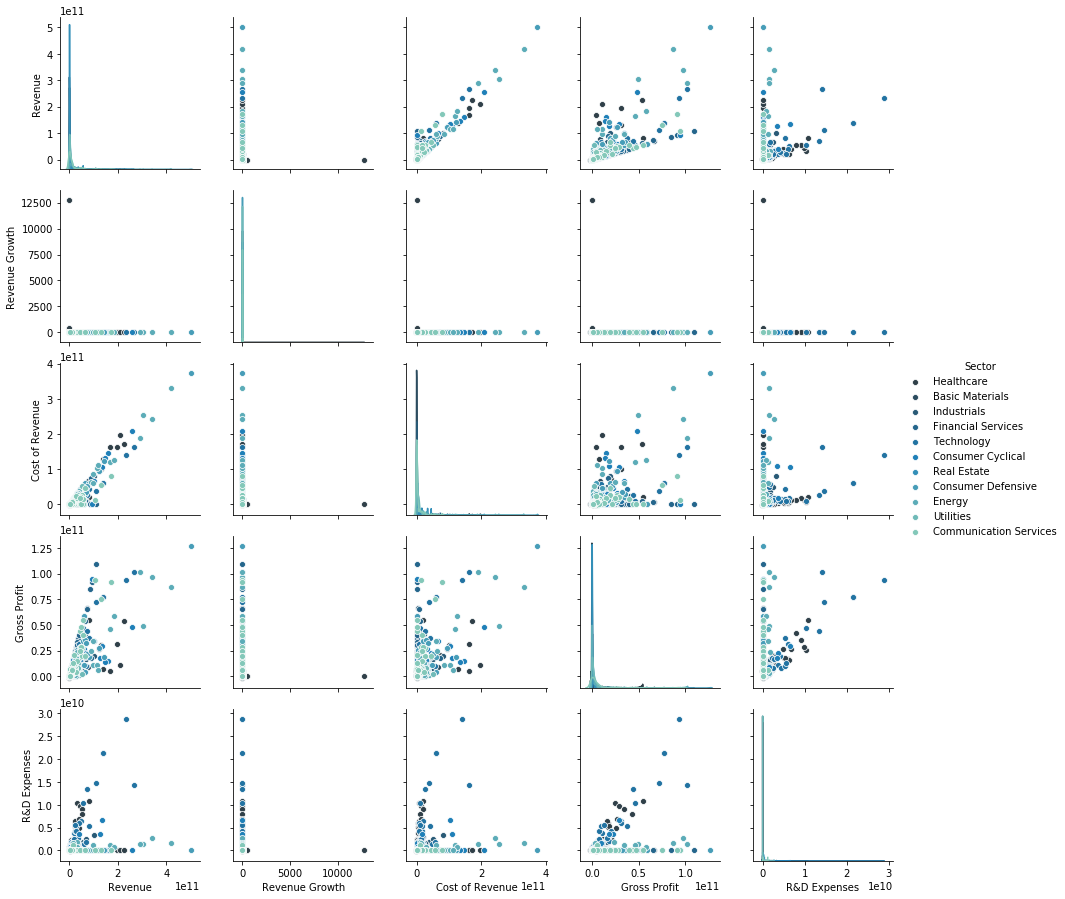

In [86]:
sns.pairplot(df, vars = ['Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses'], dropna = True, hue='Sector', palette='YlGnBu_d')

In [ ]:
# df.to_csv(os.path.join('2018_data.csv'))